In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Mini_project_Sem-6

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Alzheimers


In [5]:
%ls

AD_Model_Inception_V3.h5              train/
AD_Model_VGG19.h5                     VGG19_Confusion_Matrix.png
Diksha_1918328_miniprojectreport.pdf  VGG19_ct_accuracy.png
Inception.ipynb                       VGG19_dem_loss.png
Inception_V3_Confusion_Matrix.png     VGG19.ipynb
Inception_V3_ct_accuracy.png          VGG19_ROC.png
Inception_V3_dem_loss.png             Weights_AD_Model_Inception_V3.hdf5
Inception_V3_ROC.png                  Weights_AD_Model_VGG19.hdf5
tests/


Import Libraries and Dependencies

In [6]:
from builtins import range, input
!sudo pip3 install keras
from keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from keras.models import Model, load_model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
IMAGE_SIZE = [229,229]

epochs = 10
batch_size = 4

Image data Preprocessing

***Classification of Categories***

In [8]:
dement_path = '/gdrive/My Drive/Mini_project_Sem-6/train/mildDemented'
nondement_path = '/gdrive/My Drive/Mini_project_Sem-6/train/nonDemented'

In [9]:
NonDemfiles = glob( nondement_path +'/*' )
Demfiles = glob( dement_path + '/*' )

In [10]:
print("First 5 NonDemented Files: ",NonDemfiles[0:5])
print("Total Count: ",len(NonDemfiles))
print("First 5 MildDemented Files: ",Demfiles[0:5])
print("Total Count: ",len(Demfiles))

First 5 NonDemented Files:  ['/gdrive/My Drive/Mini_project_Sem-6/train/nonDemented/nonDem4.jpg', '/gdrive/My Drive/Mini_project_Sem-6/train/nonDemented/nonDem0.jpg', '/gdrive/My Drive/Mini_project_Sem-6/train/nonDemented/mildDem9.jpg', '/gdrive/My Drive/Mini_project_Sem-6/train/nonDemented/mildDem8.jpg', '/gdrive/My Drive/Mini_project_Sem-6/train/nonDemented/nonDem1.jpg']
Total Count:  10
First 5 MildDemented Files:  ['/gdrive/My Drive/Mini_project_Sem-6/train/mildDemented/mildDem4.jpg', '/gdrive/My Drive/Mini_project_Sem-6/train/mildDemented/mildDem7.jpg', '/gdrive/My Drive/Mini_project_Sem-6/train/mildDemented/mildDem3.jpg', '/gdrive/My Drive/Mini_project_Sem-6/train/mildDemented/mildDem1.jpg', '/gdrive/My Drive/Mini_project_Sem-6/train/mildDemented/mildDem6.jpg']
Total Count:  10


In [11]:
Dem_labels = []
NonDem_labels = []

Dem_images=[]
NonDem_images=[]

for i in range(len(Demfiles)):
  image = cv2.imread(Demfiles[i]) 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
  image = cv2.resize(image,(229,229)) 
  Dem_images.append(image) 
  Dem_labels.append('Demented') 
for i in range(len(NonDemfiles)):
  image = cv2.imread(NonDemfiles[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(229,229))
  NonDem_images.append(image)
  NonDem_labels.append('NonDemented')

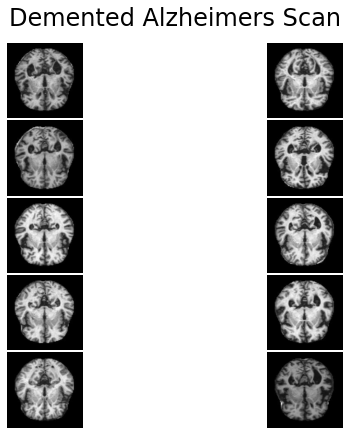

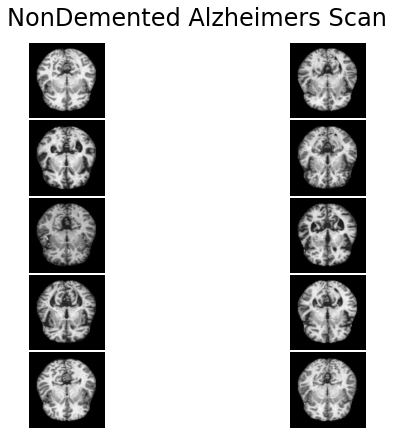

In [12]:
def plot_images(images, title):
    nrows, ncols = 5, 2
    figsize = [10, 6]
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i,axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(Dem_images, 'Demented Alzheimers Scan')
plot_images(NonDem_images, 'NonDemented Alzheimers Scan')

In [13]:
Dem_images = np.array(Dem_images) / 255
NonDem_images = np.array(NonDem_images) / 255

***Spliting dataset into training set and test set***

In [14]:
Dem_x_train, Dem_x_test, Dem_y_train, Dem_y_test = train_test_split(
    Dem_images, Dem_labels,test_size=0.2)
NonDem_x_train, NonDem_x_test, NonDem_y_train, NonDem_y_test = train_test_split(
    NonDem_images, NonDem_labels,test_size=0.2)


X_train = np.concatenate((NonDem_x_train, Dem_x_train), axis=0)
X_test = np.concatenate((NonDem_x_test, Dem_x_test), axis=0)
y_train = np.concatenate((NonDem_y_train, Dem_y_train), axis=0)
y_test = np.concatenate((NonDem_y_test, Dem_y_test), axis=0)

y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

**Building and Visualizing VGG19 Model**

In [15]:
VGGmodel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(229, 229, 3)))

outputs = VGGmodel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.4)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=VGGmodel.input, outputs=outputs)

for layer in VGGmodel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

80150528/80134624 [==============================] - 0s 0us/step


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 229, 229, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 229, 229, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 229, 229, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 114, 114, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 114, 114, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 114, 114, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 57, 57, 128)       0     

***Image Augumentation***

Training images at various angles, flips,positions etc.

In [17]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

Training the model

In [18]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/10
4/4 [==============================] - 14s 3s/step - loss: 1.6066 - accuracy: 0.4375 - val_loss: 2.1113 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 13s 3s/step - loss: 3.4611 - accuracy: 0.5000 - val_loss: 1.0580 - val_accuracy: 0.5000
Epoch 3/10
4/4 [==============================] - 13s 3s/step - loss: 1.5850 - accuracy: 0.5000 - val_loss: 2.8668 - val_accuracy: 0.5000
Epoch 4/10
4/4 [==============================] - 13s 3s/step - loss: 1.6726 - accuracy: 0.5625 - val_loss: 1.0218 - val_accuracy: 0.5000
Epoch 5/10
4/4 [==============================] - 13s 3s/step - loss: 1.7356 - accuracy: 0.5000 - val_loss: 1.3254 - val_accuracy: 0.5000
Epoch 6/10
4/4 [==============================] - 14s 4s/step - loss: 0.8621 - accuracy: 0.5000 - val_loss: 1.8234 - val_accuracy: 0.5000
Epoch 7/10
4/4 [==============================] - 15s 4s/step - loss: 1.6592 - accuracy: 0.5625 - val_loss: 1.8212 - val_accuracy: 0.5000
Epoch 8/10
4/4 [==================

In [19]:
model.save('AD_Model_VGG19.h5')
model.save_weights('Weights_AD_Model_VGG19.hdf5')

Predicting trained model on test set

In [20]:
model = load_model('AD_Model_VGG19.h5')

In [21]:
y_pred = model.predict(X_test, batch_size=batch_size)

Visualizing predicted classes

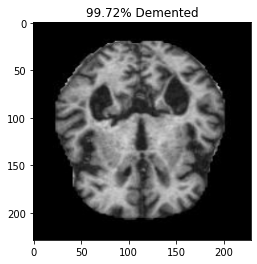

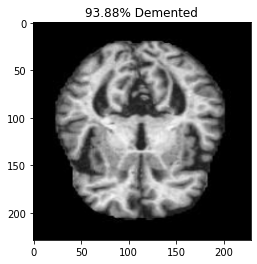

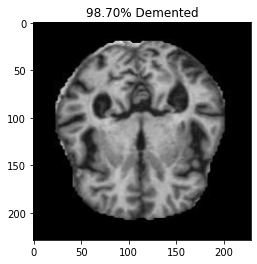

In [22]:
prediction=y_pred[1:10]
for index, probability in enumerate(prediction):
  if probability.item(0) > 0.5:
        plt.title('%.2f' % (probability.item(0)*100) + '% Demented')
  else:
        plt.title('%.2f' % ((1-probability.item(0))*100) + '% NonDemented')
  plt.style.reload_library
  plt.imshow(Dem_images[index])
  plt.show()

ROC Graph

In [23]:
y_pred_bin,y_test_bin=None,None
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

AUC: 0.500


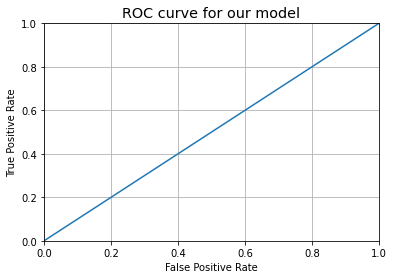

In [24]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
auc = roc_auc_score(y_test_bin, y_pred_bin)
print('AUC: %.3f' % auc)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('VGG19_ROC.png')
plt.grid(True)

Confusion Matrix without Normalization


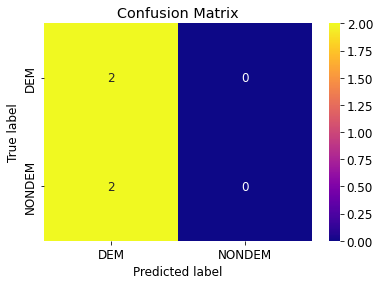

Confusion Matrix with Normalized Values


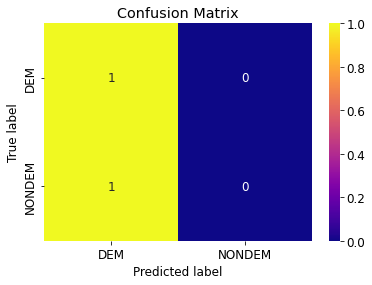

In [25]:
def plot_confusion_matrix(normalize):
  classes = ['DEM','NONDEM']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig('VGG19_Confusion_Matrix.png')
  plt.show()
 
print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)
 
print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.00      0.00      0.00         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


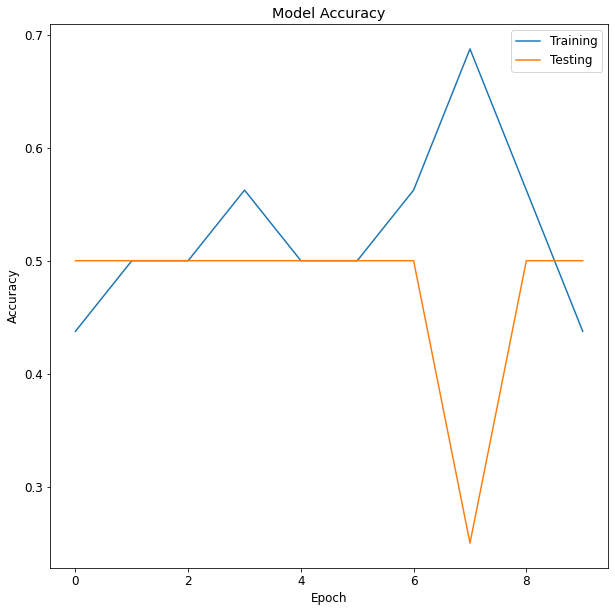

In [27]:
plt.figure(figsize=(10,10))
 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
 
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
 
plt.legend(['Training', 'Testing'])
plt.savefig('VGG19_ct_accuracy.png')
plt.show()

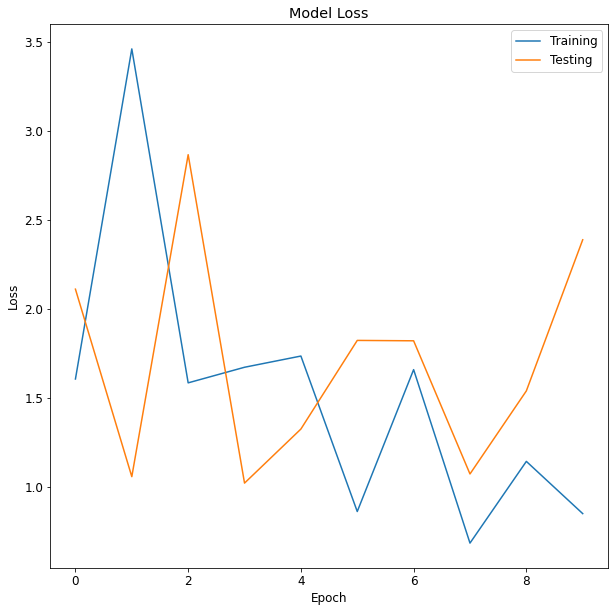

In [28]:
plt.figure(figsize=(10,10))
 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
 
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
 
plt.legend(['Training', 'Testing'])
plt.savefig('VGG19_dem_loss.png')
plt.show()